In [2]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

In [3]:
baseDir = "./save/server2Models/vrnn/vrnn1/"
# predsVT = torch.load(baseDir+"validation_preds", map_location="cpu")
# targetsVT = torch.load(baseDir+"validation_targets", map_location="cpu")
# inputsVT = torch.load(baseDir+"validation_datas", map_location="cpu")
# predsTT = torch.load(baseDir+"train_preds", map_location="cpu")
# targetsTT = torch.load(baseDir+"train_targets", map_location="cpu")
# inputsTT = torch.load(baseDir+"train_datas", map_location="cpu")

meansVT = torch.load(baseDir+"validation_means", map_location="cpu")
stdsVT = torch.load(baseDir+"validation_stds", map_location="cpu")
targetsVT = torch.load(baseDir+"validation_targets", map_location="cpu")
inputsVT = torch.load(baseDir+"validation_datas", map_location="cpu")
meansTT = torch.load(baseDir+"train_means", map_location="cpu")
stdsTT = torch.load(baseDir+"train_stds", map_location="cpu")
targetsTT = torch.load(baseDir+"train_targets", map_location="cpu")
inputsTT = torch.load(baseDir+"train_datas", map_location="cpu")

In [4]:
# predsT = np.concatenate(predsTT, axis=1)
# targetsT = np.concatenate(targetsTT, axis=1)
# datasT = np.concatenate(inputsTT, axis=1)

# predsV = np.concatenate(predsVT, axis=1)
# targetsV = np.concatenate(targetsVT, axis=1)
# datasV = np.concatenate(inputsVT, axis=1)

meansT = np.concatenate([p for p in meansTT], axis=1)
stdsT = np.concatenate([p for p in stdsTT], axis=1)
targetsT = np.concatenate([t for t in targetsTT], axis=1)
datasT = np.concatenate([d for d in inputsTT], axis=1)

meansV = np.concatenate([p for p in meansVT], axis=1)
stdsV = np.concatenate([p for p in stdsVT], axis=1)
targetsV = np.concatenate([t for t in targetsVT], axis=1)
datasV = np.concatenate([d for d in inputsVT], axis=1)

In [5]:
targetsV.shape

(12, 2775, 207)

In [6]:
datasV.shape

(12, 2775, 207)

In [7]:
datasT.shape

(12, 19203, 207)

In [8]:
targetsT.shape

(12, 19203, 207)

In [9]:
def plotRandomInstance(preds,targets, datas, dataset):
    instance = np.random.randint(targets.shape[1])
    sensor = np.random.randint(targets.shape[2])
    p = preds[:, instance, sensor]
    t = targets[:, instance, sensor]
    d = datas[:,instance, sensor]
    plt.plot(range(0,60, 5),p, label="Pred")
    #plt.fill_between(range(0,60, 5),m-1.96*std, m+1.96*std)
    plt.plot(range(0,60, 5),t, label="target")
    plt.plot(range(-60,0, 5), d, label="input")
    plt.legend()
    plt.xlabel("Minutes relative to prediction time")
    plt.ylabel("Speed (mph)")
    plt.title("random sensor sample {}".format(dataset))
    plt.show()

In [19]:
def plotRandomInstanceVRNN(means, stds, targets, datas, dataset):
    instance = np.random.randint(targets.shape[1])
    sensor = np.random.randint(targets.shape[2])
    m = means[:, instance, sensor]
    std = stds[:, instance, sensor]
    t = targets[:, instance, sensor]
    d = datas[:,instance, sensor]
    print(std)
    plt.plot(range(0,60, 5),m, label="Pred")
    #plt.fill_between(range(0,60, 5),m-1.96*std, m+1.96*std)
    plt.plot(range(0,60, 5),t, label="target")
    plt.plot(range(-60,0, 5), d, label="input")
    plt.legend()
    plt.xlabel("Minutes relative to prediction time")
    plt.ylabel("Speed (mph)")
    plt.title("random sensor sample {}".format(dataset))
    plt.show()

[54.5084   54.43755  54.438244 54.43821  54.4275   54.419384 54.41828
 54.41814  54.41799  54.417984 54.417934 54.417866]


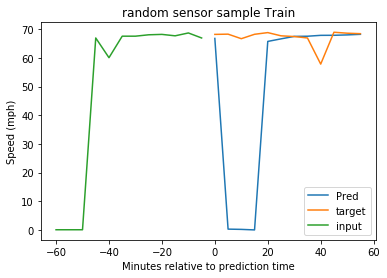

In [73]:
plotRandomInstanceVRNN(meansT,stdsT, targetsT, datasT, "Train")

[55.11213  54.99232  54.989758 54.989628 54.989395 54.989376 54.989372
 54.98938  54.989376 54.98934  54.98926  54.989323]


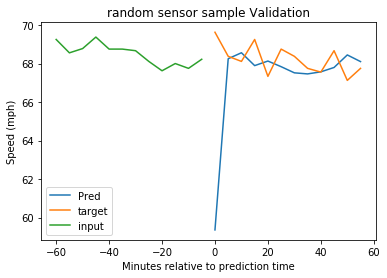

In [77]:
plotRandomInstanceVRNN(meansV, stdsV, targetsV, datasV, "Validation")